In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.regression.linear_model import RegressionResultsWrapper
from arch import arch_model

with open("../data/significant_alphas_list.txt", "r") as f:
    SIGNIFICANT_ALPHAS_LIST: list[str] = f.read().splitlines()

# data
test_ticker: str = "BLDR"

test_returns: pd.Series = pd.read_csv("../data/stock_returns.csv", index_col=0, parse_dates=True)[test_ticker].dropna()
factor_returns: pd.DataFrame = pd.read_csv("../data/factor_returns.csv", index_col=0, parse_dates=True).drop(columns=["rf"])
alphas: pd.DataFrame = pd.read_csv(f"../data/alphas_by_symbol/{test_ticker}.csv", index_col=0, parse_dates=True)[SIGNIFICANT_ALPHAS_LIST]

# concat data to make sure they are aligned
concat_data = pd.concat([test_returns, factor_returns, alphas], axis=1, join="inner")
test_returns = concat_data.iloc[:, 0]
test_residuals = concat_data.iloc[:, 1]
factor_returns = concat_data.iloc[:, 2:2 + len(factor_returns.columns)]
alphas = concat_data.iloc[:, 2 + len(factor_returns.columns):]


## Residual against alphas OLS

- residuals: t
- alphas: t-1

In [2]:
y = test_returns.shift(-1).dropna()
X = alphas.loc[y.index].copy()

# OLS
model = OLS(y, X)
model_fit = model.fit()

# select alphas significant at 5% level
significant_alphas = model_fit.pvalues[model_fit.pvalues < 0.05].index.tolist()
X = X[significant_alphas]

## Find Best ARMA model

loop p: 0-5  
loop q: 0-5  
    fit ARMA(p,q) to residuals  
    save AIC, BIC, HQIC  
end loop  

select best model based on AIC, BIC, HQIC

In [3]:
# import ARMA
from statsmodels.tsa.arima.model import ARIMA

def get_p_q(y: pd.Series, X: pd.DataFrame) -> tuple[int, int]:
    """
    Get p and q for GARCH model
    """
    AICs = []
    for p in range(1, 4):
        for q in range(1, 4):
            try:
                model = ARIMA(y, order=(p, 0, q), exog=X)
                model_fit = model.fit()
                AICs.append((p, q, model_fit.aic))
            except:
                continue
    # return the p and q with the lowest AIC
    
    p, q, _ = min(AICs, key=lambda x: x[2])
    return p, q

In [4]:
p, q = get_p_q(y, X)

/opt/homebrew/Caskroom/miniconda/base/envs/FTS/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/FTS/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/FTS/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/FTS/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelih

In [5]:
p, q

(1, 1)

In [6]:
model = ARIMA(y, order=(p, 0, q), exog=X)
model_fit = model.fit()
model_fit.summary()

/opt/homebrew/Caskroom/miniconda/base/envs/FTS/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/FTS/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/FTS/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/FTS/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelih

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   BLDR   No. Observations:                  251
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 554.460
Date:                Wed, 23 Apr 2025   AIC                          -1094.920
Time:                        17:29:38   BIC                          -1070.242
Sample:                             0   HQIC                         -1084.989
                                - 251                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.005      0.837      0.403      -0.005       0.013
alpha017      -0.0214      0.011     -1.883      0.060      -0.044       0.001
alpha034      -0.0055      0.007     -0.734      0.463      -0.020       0.009
alpha035   -2.109e-06   7.13e-07     -2.958      0.003   -3.51e-06   -7.12e-07
ar.L1         -0.0323      1.894     -0.017      0.986      -3.745       3.681
ma.L1         -0.0099      1.889     -0.005      0.996      -3.713       3.693
sigma2         0.0007   4.58e-05     15.481      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               396.70
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                            -0.72
Prob(H) (two-sided):                  0.23   Kurtosis:                         8.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
# make predictions
periods = 1
predictions = model_fit.forecast(steps=periods, exog=alphas[significant_alphas].iloc[-periods:])
predictions


/opt/homebrew/Caskroom/miniconda/base/envs/FTS/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/Caskroom/miniconda/base/envs/FTS/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


251    0.000411
dtype: float64

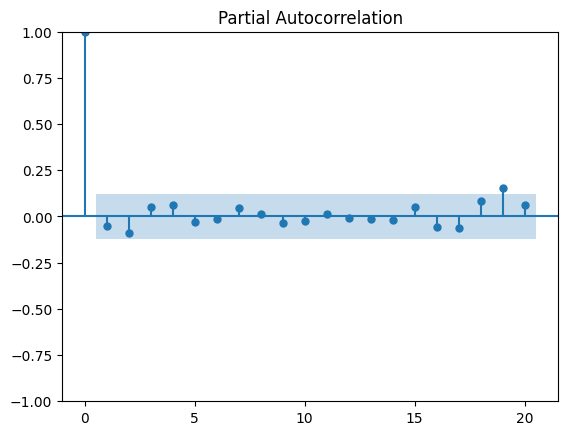

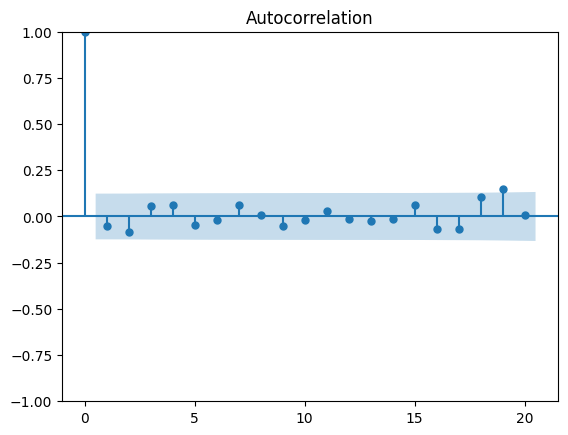

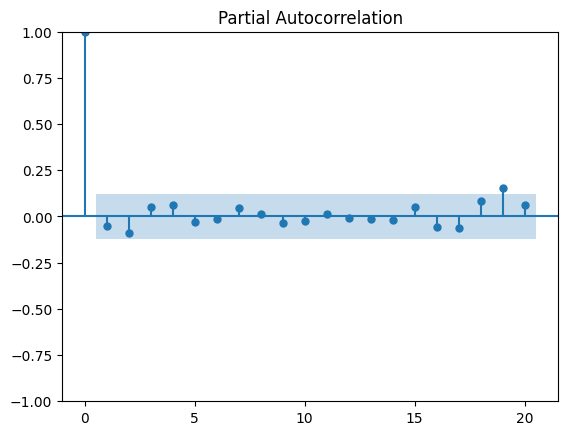

In [7]:
# PACF and ACF 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# plot ACF and PACF

plot_acf(y, lags=20)
plot_pacf(y, lags=20)